In [1]:
%env CUDA_LAUNCH_BLOCKING=1


env: CUDA_LAUNCH_BLOCKING=1


In [2]:
import torch
torch.cuda.empty_cache()

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim.downloader
from transformers import pipeline

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from transformers import AutoTokenizer, BertModel
import torch


In [4]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [5]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\acer\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
df_train=pd.read_csv('labeled_data.csv')

In [7]:
# No empty data..plus Id is there, which I don't need. So, I'm dropping it
df_train.drop(labels=['Unnamed: 0'],axis=1,inplace=True)

In [8]:
df_train.loc[(df_train['class']== 0),'class']=1

In [9]:
df_train.loc[(df_train['class']==2),'class']=0


In [10]:
hatespeech=df_train[df_train['class']==1]['class'].count()
not_hatespeech=df_train[df_train['class']==0]['class'].count()

Text(0.5, 1.0, 'Class Distribution')

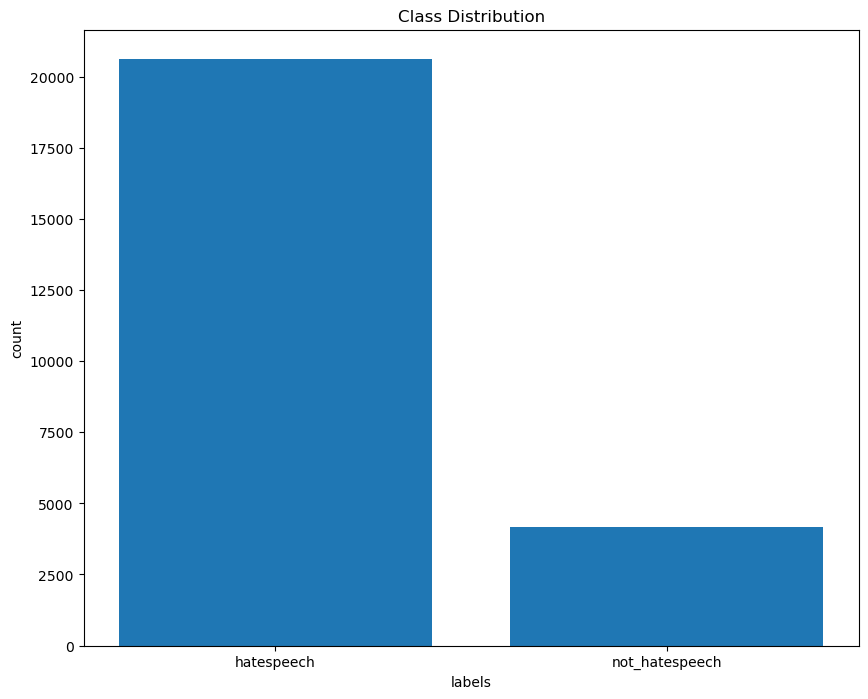

In [11]:
plt.figure(figsize=(10,8))
plt.bar(x=['hatespeech','not_hatespeech'],height=[hatespeech,not_hatespeech])
plt.xlabel('labels')
plt.ylabel('count')
plt.title('Class Distribution')

In [12]:
X=df_train['tweet']
y=df_train['class']

In [13]:
y.value_counts()

1    20620
0     4163
Name: class, dtype: int64

In [14]:
import torch
print(torch.cuda.is_available())  # Should return True if GPU is available


True


In [15]:

# Define the model name
model_name = "bert-base-uncased"

# Load the tokenizer and model using Auto classes
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(row):
    row = row.lower()
    row = re.sub(r'[^\w\s]', '', row)
    words = row.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words) if words else 'empty'

        

In [17]:
x_preprocessed = [preprocess(row) for row in X]


In [18]:
train_x, eval_x, train_y, eval_y = train_test_split(x_preprocessed, y, test_size=0.2, stratify=y)

train_data = {'text': train_x, 'labels': train_y}
train_dataset = Dataset.from_dict(train_data)

eval_data = {'text': eval_x, 'labels': eval_y}
eval_dataset = Dataset.from_dict(eval_data)

In [19]:
# Tokenize the train and eval datasets
def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding=True, max_length=512)

# Apply tokenization
train_dataset = train_dataset.map(tokenize_function, batched=True)
eval_dataset = eval_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/19826 [00:00<?, ? examples/s]

Map:   0%|          | 0/4957 [00:00<?, ? examples/s]

In [20]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
model.to(device) 

Using device: cuda


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [21]:
# Define training arguments with logging and evaluation strategy
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",  # set to 'steps'
    logging_dir="./logs",  # Directory to store logs
    logging_steps=500,  # Log every 100 steps
    save_strategy="epoch",  # Save checkpoint every 'steps'
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=6,
    weight_decay=0.01,
    report_to="tensorboard",  # This will allow me to visualize the metrics with TensorBoard
)

# Initialize the Trainer with the training arguments
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    tokenizer=tokenizer
)


C:\Users\acer\anaconda3\Lib\site-packages\transformers\training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
C:\Users\acer\AppData\Local\Temp\ipykernel_5056\1416846506.py:17: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [22]:
# Train the model
trainer.train()

Epoch,Training Loss,Validation Loss
1,0.155400,0.153920
2,0.119600,0.146352
3,0.084800,0.203301
4,0.031400,0.238037
5,0.029400,0.253288
6,0.006000,0.336003


TrainOutput(global_step=14874, training_loss=0.0747710070703657, metrics={'train_runtime': 5577.4842, 'train_samples_per_second': 21.328, 'train_steps_per_second': 2.667, 'total_flos': 8839198432600680.0, 'train_loss': 0.0747710070703657, 'epoch': 6.0})

In [23]:

# Get predictions and true labels from the eval dataset
predictions = trainer.predict(eval_dataset)
predicted_labels = predictions.predictions.argmax(axis=-1)
true_labels = predictions.label_ids

In [24]:
# Calculate metrics
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels)
recall = recall_score(true_labels, predicted_labels)
f1 = f1_score(true_labels, predicted_labels)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Confusion Matrix:\n{conf_matrix}")
tn, fp, fn, tp = conf_matrix.ravel()
print(tn, fp, fn, tp)

Accuracy: 0.9604599556183175
Precision: 0.9748549323017408
Recall: 0.9776915615906887
F1 Score: 0.976271186440678
Confusion Matrix:
[[ 729  104]
 [  92 4032]]
729 104 92 4032


In [25]:
# Saving the model
trainer.save_model("./saved_model")

# Saving the tokenizer
tokenizer.save_pretrained("./saved_model")



('./saved_model\\tokenizer_config.json',
 './saved_model\\special_tokens_map.json',
 './saved_model\\vocab.txt',
 './saved_model\\added_tokens.json',
 './saved_model\\tokenizer.json')